In [3]:
%load_ext jupyter_black

# Libraries
import json
import csv
import pandas as pd
import os
import re

import requests
from PIL import Image

from ollama import chat
from ollama import ChatResponse
import base64
from io import BytesIO

from tqdm.notebook import tqdm

# for showing image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

%matplotlib inline

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


In [4]:
# set target dataset and file locations
target_caption_dataset_filename = "./data/caption-dataset/annotations/train.json"
image_folder = "./data/clean-images"
filenames = next(os.walk(image_folder), (None, None, []))[2]

# get image quality annotations
target_image_quality_dataset_filename = (
    "./data/image-quality-assessment/annotations/train.json"
)

In [5]:
# get images and annotations in one dataframe
image_annotation_df = None
with open(target_caption_dataset_filename) as f:
    # load caption dataset
    caption_dataset_json = json.load(f)

    # combine image files and annotations
    images_df = pd.DataFrame.from_dict(caption_dataset_json["images"])
    annotations_df = pd.DataFrame.from_dict(caption_dataset_json["annotations"])
    grouped_annotations = (
        annotations_df.groupby(["image_id"]).agg(tuple).map(list).reset_index()
    )
    image_annotation_df = images_df.merge(
        grouped_annotations[["image_id", "caption", "is_precanned", "is_rejected"]],
        left_on="id",
        right_on="image_id",
    )

    # vizwiz_url is broken, so fix with https://vizwiz.cs.colorado.edu/*
    image_annotation_df["vizwiz_url"] = image_annotation_df["vizwiz_url"].apply(
        lambda x: x.replace(
            "https://ivc.ischool.utexas.edu/", "https://vizwiz.cs.colorado.edu/"
        )
    )


image_annotation_df

,file_name,vizwiz_url,id,text_detected,image_id,caption,is_precanned,is_rejected
0,VizWiz_train_00000000.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,0,True,0,[ITS IS A BASIL LEAVES CONTAINER ITS CONTAINS ...,"[False, False, True, False, False]","[False, False, True, False, False]"
1,VizWiz_train_00000001.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,1,True,1,[A can of Coca Cola on a counter is shown for ...,"[False, False, False, False, False]","[False, False, False, False, False]"
2,VizWiz_train_00000002.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,2,True,2,[A can of crushed tomatoes are on a brown surf...,"[False, False, False, False, False]","[False, False, False, False, False]"
3,VizWiz_train_00000003.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,3,True,3,[A white screen with a captcha that needs to b...,"[False, False, False, False, False]","[False, False, False, False, False]"
4,VizWiz_train_00000004.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,4,True,4,[A box for a garden light rests in someone's l...,"[False, False, False, False, False]","[False, False, False, False, False]"
...,...,...,...,...,...,...,...,...
23426,VizWiz_train_00023426.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,23426,True,23426,[A PlayStation 2 video game that is for the sp...,"[False, False, False, False, False]","[False, False, False, False, False]"
23427,VizWiz_train_00023427.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,23427,False,23427,[A folded paper currency with a depiction of a...,"[False, True, False, False, True]","[False, False, False, False, False]"
23428,VizWiz_train_00023428.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,23428,True,23428,[A black and white sheet of paper with font le...,"[False, False, False, False, False]","[False, False, False, False, False]"
23429,VizWiz_train_00023429.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,23429,True,23429,[A bottle of Healthy Hair Skin & Nails capsule...,"[False, False, False, False, False]","[False, False, False, False, False]"


In [6]:
# get image quality
image_quality_annotation_df = None
with open(target_image_quality_dataset_filename) as f:
    # load image quality annotation dataset
    image_quality_dataset_json = json.load(f)
    image_quality_df = pd.DataFrame.from_dict(image_quality_dataset_json)

    # expand object of flaws into individual columns and rename
    image_quality_df = pd.concat(
        [
            image_quality_df.drop(["flaws"], axis=1),
            pd.json_normalize(image_quality_df["flaws"]),
        ],
        axis=1,
    )
    image_quality_df.rename(
        columns={
            "FRM": "framing",
            "BLR": "blur",
            "DRK": "too dark",
            "BRT": "too bright",
            "OBS": "obstruction",
            "OTH": "other",
            "NON": "no issue",
            "ROT": "rotation",
        },
        inplace=True,
    )

image_quality_df

,image,unrecognizable,framing,blur,too dark,too bright,obstruction,other,no issue,rotation
0,VizWiz_train_00022585.jpg,4,1,5,0,3,0,0,0,0
1,VizWiz_train_00004143.jpg,1,4,3,0,0,0,0,1,0
2,VizWiz_train_00002092.jpg,5,0,3,2,0,1,2,0,0
3,VizWiz_train_00008936.jpg,1,4,4,0,0,1,0,0,0
4,VizWiz_train_00020927.jpg,0,0,2,0,0,0,0,3,0
...,...,...,...,...,...,...,...,...,...,...
23426,VizWiz_train_00020740.jpg,2,3,3,1,1,1,0,1,0
23427,VizWiz_train_00014487.jpg,0,0,1,0,0,0,0,1,4
23428,VizWiz_train_00005846.jpg,1,4,0,2,0,0,0,1,0
23429,VizWiz_train_00017677.jpg,0,3,1,0,0,0,1,1,0


In [7]:
# combine image and quality datasets together
image_captioning_input = image_annotation_df.merge(
    image_quality_df, left_on="file_name", right_on="image"
).drop(["image"], axis=1)

In [8]:
# filter input for only the selected clean images
filtered_images_df = image_captioning_input.query("file_name.isin(@filenames)")
filtered_images_df["model_caption"] = ""
dataset_to_caption = filtered_images_df.to_dict("records")

filtered_images_df

/var/folders/6w/gkg9vw3d29jglv9knrxxf3r40000gn/T/ipykernel_19727/826547608.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_images_df["model_caption"] = ""


,file_name,vizwiz_url,id,text_detected,image_id,caption,is_precanned,is_rejected,unrecognizable,framing,blur,too dark,too bright,obstruction,other,no issue,rotation,model_caption
0,VizWiz_train_00000000.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,0,True,0,[ITS IS A BASIL LEAVES CONTAINER ITS CONTAINS ...,"[False, False, True, False, False]","[False, False, True, False, False]",1,3,1,0,0,0,1,1,0,
12,VizWiz_train_00000012.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,12,True,12,[a jvc DVD and vcr remote someone has in their...,"[False, False, False, False, False]","[False, False, False, False, False]",0,0,1,0,0,0,0,4,0,
40,VizWiz_train_00000040.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,40,True,40,[Bar code that appears to be off of a piece of...,"[False, False, False, False, False]","[False, False, False, False, False]",0,4,1,0,0,0,1,0,0,
43,VizWiz_train_00000043.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,43,True,43,[a container of apple pie spice containing gin...,"[False, False, False, False, False]","[False, False, False, False, False]",0,2,1,0,0,0,0,1,3,
44,VizWiz_train_00000044.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,44,True,44,[Heinz rice and chicken frozen TV dinner In a...,"[False, False, False, False, False]","[False, True, False, False, False]",0,3,1,0,0,0,0,1,1,
49,VizWiz_train_00000049.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,49,True,49,[A Kirkland water bottle is sitting on a count...,"[False, False, False, False, False]","[False, False, False, False, False]",0,1,1,0,0,0,0,3,1,
50,VizWiz_train_00000050.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,50,True,50,[A plastic container of a dairy product with t...,"[False, False, False, False, False]","[False, False, False, False, False]",0,0,1,0,0,0,0,4,0,
23146,VizWiz_train_00023146.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,23146,True,23146,[A yellow hi-liter sitting on a marbled counte...,"[False, False, False, False, False]","[False, False, False, False, False]",0,1,0,0,0,0,0,4,0,
23326,VizWiz_train_00023326.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,23326,False,23326,[A cat standing in the hallway with wooden flo...,"[False, False, False, False, False]","[False, False, False, False, False]",0,0,0,0,0,0,0,5,0,
23356,VizWiz_train_00023356.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,23356,False,23356,[An orange and a lemon sitting out on the coun...,"[False, False, False, False, False]","[False, False, False, False, False]",0,0,0,0,0,0,0,5,0,


In [9]:
# model prompt
system_prompt = {
    "role": "system",
    "content": "You are a program designed to help blind and low-vision users understand images. When asked about the image, generate accessible image description that includes key visual and contextual details of the image for blind and low-vision people. Focus on the following principles: Clarity and Conciseness: Use simple, straightforward language to describe the main subjects and their relationships.; Relevance: Highlight only essential visual elements that contribute to understanding the image or its purpose.; Context: Provide contextual information when necessary, such as emotional tone, setting, or action. Avoid assumptions or subjective interpretations.; Specificity: Include important details like colors, shapes, textures, or text visible in the image, if relevant. Avoid overly general terms or unnecessary details. Once you generate your caption, shorten it to a succinct, single sentence. Output only the final sentence.",
}

for index, row in enumerate(tqdm(dataset_to_caption)):
    # get image for current annotation
    image_file = os.path.join(image_folder, dataset_to_caption[index]["file_name"])

    # generate output and store in dict
    response: ChatResponse = chat(
        model="llama3.2-vision",
        messages=[
            system_prompt,
            {
                "role": "user",
                "content": "Can you please tell me what is in this image?",
                "images": [image_file],
            },
        ],
    )
    dataset_to_caption[index]["model_caption"] = response["message"]["content"]

  0%|          | 0/10 [00:00<?, ?it/s]

## Testing Defocus Blur before captioning
[Defocus](https://albumentations.ai/docs/api_reference/augmentations/blur/transforms/#albumentations.augmentations.blur.transforms.Defocus) blur simulates out-of-focus cameras (which can happen if a BLV person is taking a picture) by applying both a disc kernal and Gaussian blur to the image. The blur is specified by 3 parameters:
- `radius (tuple[int, int], int)`: Range for the radius of the defocus blur. If a single int is provided, the range will be [1, radius]. Larger values create a stronger blur effect. **I use 10, 20, 30 to correspond to light, medium, and heavy blurring for now. Heavy blurring does not make the image illegible**
- `alias_blur (tuple[float, float] | float)`: Range for the standard deviation of the Gaussian blur applied after the main defocus blur. This helps to reduce aliasing artifacts. If a single float is provided, the range will be (0, alias_blur). Larger values create a smoother, more aliased effect. **I fix this to (0.2, 0.4)**
- `p (float)`: probability of applying transform. This is used in a data augmentation pipeline where one wants to try various combinations of transformations during training / evaluation. **Since we always want a blur, `p = 1.0` below**

The defocus effect is created using a disc kernel, which simulates the shape of a camera's aperture, with a larger `radius` causing a more noticable defocusing effect. The Gaussian blur specified by `alias_blur` helps to soften the edges of the disc kernel, creating a more natural-looking defocus effect.

In [10]:
import albumentations as A
import numpy as np


def pil_to_base64(pil_image):
    im_file = BytesIO()
    pil_image.save(im_file, format="JPEG")
    im_bytes = im_file.getvalue()  # im_bytes: image in binary format.
    return base64.b64encode(im_bytes).decode("utf-8")

### Testing blur settings

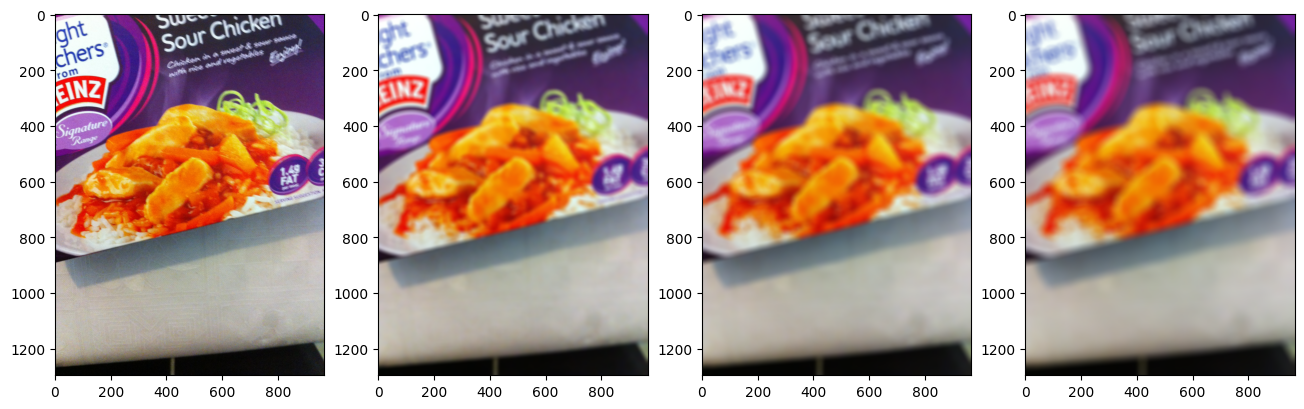

In [11]:
# set-up a plot to show the images
rcParams["figure.figsize"] = 16, 8
fig, ax = plt.subplots(1, 4)
plt_counter = 0

# show original image
pillow_image = Image.open(
    os.path.join(image_folder, dataset_to_caption[4]["file_name"])
)
ax[plt_counter].imshow(pillow_image)
plt_counter += 1

# apply varying levels of defocus
disc_blur_settings = [10, 15, 20]
image_np = np.array(pillow_image)
for setting in disc_blur_settings:
    blur_transform = A.Compose(
        [A.Defocus(radius=(setting, setting), alias_blur=(0.6, 0.6), p=1.0)], p=1.0
    )
    blurred_image_np = blur_transform(image=image_np)["image"]
    blurred_image_pil = Image.fromarray(np.uint8(blurred_image_np)).convert("RGB")
    ax[plt_counter].imshow(blurred_image_pil)
    plt_counter += 1

In [12]:
# add placeholder for blurred captions
for item in dataset_to_caption:
    item["low_blur_model_caption"] = ""
    item["med_blur_model_caption"] = ""
    item["high_blur_model_caption"] = ""

In [13]:
# model prompt
system_prompt = {
    "role": "system",
    "content": "You are a program designed to help blind and low-vision users understand images. When asked about the image, generate accessible image description that includes key visual and contextual details of the image for blind and low-vision people. Focus on the following principles: Clarity and Conciseness: Use simple, straightforward language to describe the main subjects and their relationships.; Relevance: Highlight only essential visual elements that contribute to understanding the image or its purpose.; Context: Provide contextual information when necessary, such as emotional tone, setting, or action. Avoid assumptions or subjective interpretations.; Specificity: Include important details like colors, shapes, textures, or text visible in the image, if relevant. Avoid overly general terms or unnecessary details. Once you generate your caption, shorten it to a succinct, single sentence. Output only the final sentence.",
}

for index, row in enumerate(tqdm(dataset_to_caption)):
    # get image for current annotation
    image_file = os.path.join(image_folder, dataset_to_caption[index]["file_name"])

    # generate output for each blur
    # show original image
    pillow_image = Image.open(image_file)

    # apply varying levels of defocus
    disc_blur_settings = [
        ("low_blur_model_caption", 10),
        ("med_blur_model_caption", 15),
        ("high_blur_model_caption", 20),
    ]
    image_np = np.array(pillow_image)
    for key, setting in disc_blur_settings:
        blur_transform = A.Compose(
            [A.Defocus(radius=(setting, setting), alias_blur=(0.6, 0.6), p=1.0)], p=1.0
        )
        blurred_image_np = blur_transform(image=image_np)["image"]
        blurred_image_pil = Image.fromarray(np.uint8(blurred_image_np)).convert("RGB")

        # generate output and store in dict
        response: ChatResponse = chat(
            model="llama3.2-vision",
            messages=[
                system_prompt,
                {
                    "role": "user",
                    "content": "Can you please tell me what is in this image?",
                    "images": [pil_to_base64(blurred_image_pil)],
                },
            ],
        )
        dataset_to_caption[index][key] = response["message"]["content"]

  0%|          | 0/10 [00:00<?, ?it/s]

In [37]:
# expand human captions into separate columns
output_dataset = json.loads(json.dumps(dataset_to_caption))
for index, item in enumerate(output_dataset):
    if type(item["caption"]) == str:
        item["caption"] = [
            x.strip()
            for x in re.split(
                r'(["\'])(.*?)\1', item["caption"].replace("[", "").replace("]", "")
            )
            if x.strip() != ""
            and x.strip() != ","
            and x.strip() != "'"
            and x.strip() != '"'
        ]
    output_dataset[index]["human_caption_1"] = item["caption"][0]
    output_dataset[index]["human_caption_2"] = item["caption"][1]
    output_dataset[index]["human_caption_3"] = item["caption"][2]
    output_dataset[index]["human_caption_4"] = item["caption"][3]
    output_dataset[index]["human_caption_5"] = item["caption"][4]
    del output_dataset[index]["caption"]

In [36]:
# move model captions to end of data frame
output_df = pd.DataFrame.from_dict(output_dataset)
for col in [
    "model_caption",
    "low_blur_model_caption",
    "med_blur_model_caption",
    "high_blur_model_caption",
]:
    output_df.insert(len(output_df.columns) - 1, col, output_df.pop(col))
output_df.insert(0, "id", output_df.pop("id"))

# add a note column
output_df["notes (include initials, e.g. 'KG: ...')"] = ""

# rename columns
output_df.rename(columns={"id": "vizwiz_id"}, inplace=True)

# save file
output_df.to_csv(
    "./data/labeled-data/blurred-image-experiment_02-04-25.csv", index=False
)

# print dataframe
output_df.head()

,vizwiz_id,file_name,vizwiz_url,text_detected,image_id,is_precanned,is_rejected,unrecognizable,framing,blur,...,human_caption_1,human_caption_2,human_caption_3,human_caption_4,human_caption_5,model_caption,low_blur_model_caption,med_blur_model_caption,high_blur_model_caption,"notes (include initials, e.g. 'KG: ...')"
0,0,VizWiz_train_00000000.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,0,"[False, False, True, False, False]","[False, False, True, False, False]",1,3,1,...,ITS IS A BASIL LEAVES CONTAINER ITS CONTAINS T...,A green and white plastic condiment bottle con...,Quality issues are too severe to recognize vis...,A bottle of spices in a plastic container layi...,some basil leaves in a container on a counter,A clear plastic jar filled with dried basil le...,A small container of dried basil leaves.,A plastic jar of dried basil leaves with a gre...,The image appears to show a can of black beans...,
1,12,VizWiz_train_00000012.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,12,"[False, False, False, False, False]","[False, False, False, False, False]",0,0,1,...,a jvc DVD and vcr remote someone has in their ...,A JVC Remote Control for a DVD and VCR.,A gray remote has many buttons on it,PERSON HOLDING A TV REMOTE IN THEIR HAND,A JVC branded remote in a white hand,A white JVC DVD and VCR remote control with gr...,A white remote control with gray buttons and a...,A person is holding a white remote control wit...,A white remote control with a blue logo at the...,
2,40,VizWiz_train_00000040.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,40,"[False, False, False, False, False]","[False, False, False, False, False]",0,4,1,...,Bar code that appears to be off of a piece of ...,barcode on a shipping label with blue ink star,An airmail envelope with a bar code on it.,The blue mark is on the label by the bar code.,Partial image of an air bill used for shipping,A red and white barcode with black text that r...,The image appears to be an airline boarding pa...,A red and white air bill label with black text...,A blurry barcode and text on a beige background.,
3,43,VizWiz_train_00000043.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,43,"[False, False, False, False, False]","[False, False, False, False, False]",0,2,1,...,a container of apple pie spice containing ging...,Label on container for natural apple pie spice,A plastic container that contains apple pie sp...,"A jar of ""Apple Pie Spice"" comprised of a zest...",A container / package that contains various go...,A brown paper bag contains an oval-shaped pack...,The image shows an oval-shaped sticker with th...,A red and yellow oval-shaped label with the wo...,A red and yellow label with black text that re...,
4,44,VizWiz_train_00000044.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,44,"[False, False, False, False, False]","[False, True, False, False, False]",0,3,1,...,Heinz rice and chicken frozen TV dinner In a ...,Beautiful view from behind the walls hidden un...,a box of Weight Watchers brand sweet and sour ...,A Weight Watchers boxed dinner of Sweet & Sour...,A ready to microwave meal of Sweet and sour ch...,A box of Sweet & Sour Chicken frozen meal from...,A box of Heinz sweet and sour chicken.,A box of frozen chicken pieces with a dark pur...,A purple box with an illustration of curly fri...,
